## My bicycle reinvention in module import issue  

In [1]:
from lib import *

Pipeline = pipeline.Pipeline
RegressionValidator = pipeline.RegressionValidator

DatasetProvider = provider.DatasetProvider
DatasetUploader = provider.DatasetUploader
ExpandedWindowIterator = subset_extraction.ExpandedWindowIterator
EntityIterator = subset_extraction.EntityIterator


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import scipy
from scipy import stats

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import LabelEncoder

tr = transformers

In [3]:
df_provider = DatasetProvider()

In [4]:
dataset_paths = [
    '/home/denissimo/Repo/fs_project/datasets/sample_submission.csv',
    '/home/denissimo/Repo/fs_project/datasets/test.csv',
    '/home/denissimo/Repo/fs_project/datasets/shops.csv',
    '/home/denissimo/Repo/fs_project/datasets/item_categories.csv',
    '/home/denissimo/Repo/fs_project/datasets/sales_train.csv',
    '/home/denissimo/Repo/fs_project/datasets/items.csv'
]

In [5]:
df_provider.file_list = dataset_paths

datasets = df_provider.get_dataset()

In [6]:
sales = datasets['sales_train.csv']
items = datasets['items.csv']
categories = datasets['item_categories.csv']
shops = datasets['shops.csv']

In [7]:
force_category = {
    'category': {
        "PC - Гарнитуры/Наушники": "Аксессуары",
        "Игры MAC - Цифра": "Игры",
        "Игры Android - Цифра": "Игры",
        "Чистые носители (шпиль)": "Чистые носители",
        "Чистые носители (штучные)": "Чистые носители",
    },
    'shop': {
        'Интернет-магазин ЧС': 'Интернет-магазин',
        'Цифровой склад 1С-Онлайн': 'Склад',
        'Выездная Торговля': 'Выездная Торговля',
        '!Якутск Орджоникидзе, 56 фран': 'Якутск',
        '!Якутск ТЦ "Центральный" фран': 'Якутск',
    },
}

pattern = {
    'category': ' - ',
    'shop': ' ',
}

In [8]:
sales.date = sales.date.astype('datetime64[ns]')

print("Before:", sales.shape)

from datetime import date

sales = sales.loc[sales.date < np.datetime64(date(2015, 11, 1))]

sales_train = sales[
    (sales["item_cnt_day"] < 1000)
    & (sales["item_price"] > 0)
    & (sales["item_price"] < 60000)
].copy()
print("After:", sales_train.shape)

sales.head()

Before: (2935849, 6)
After: (2896778, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [9]:
make_cat_name = tr.create_name_transformer(force_category['category'], pattern['category'])
make_city_name = tr.create_name_transformer(force_category['shop'], pattern['shop'])

In [10]:
data_preprocessing = {}

# Add corresponding category and shop id's to each sale
data_preprocessing['id_merging_stage'] = lambda dataset: dataset.merge(
    items, 
    on='item_id'
).merge(
    shops,
    on='shop_id'
).merge(
    categories,
    on='item_category_id'
)

# Add summary among shop_id and category_id above similar time periods (daily intervals)
data_preprocessing['summarizing_and_name_merging_stage'] = lambda dataset: dataset.groupby(
    ['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_category_name', 'shop_name']
).item_cnt_day.sum().reset_index().sort_values('date')

data_preprocessing['add_generalized_names_and_encode_stage'] = lambda dataset: tr.append_columns(
    dataset=dataset, 
    columns=[
        'global_item_category_name',
        'city_name',
        'global_item_category_name_id',
        'city_id',
    ], 
    transformers=[
        lambda _dataset: _dataset["item_category_name"].apply(
            make_cat_name
        ),
        lambda _dataset: _dataset['shop_name'].apply(
            make_city_name
        ),
        lambda _dataset: LabelEncoder().fit_transform(_dataset['global_item_category_name']),
        lambda _dataset: LabelEncoder().fit_transform(_dataset['city_name']),
    ]
)

        
data_preprocessing['date_block_num_renaming'] = lambda dataset: dataset.rename(columns={'date_block_num': 'month_block'}, inplace=True)
        
data_preprocessing['date_encoding_stage'] = lambda dataset: tr.append_columns(
    dataset=dataset, 
    columns=[
        'week_block',
        'day_block',
    ], 
    transformers=[
        lambda _dataset: LabelEncoder().fit_transform(_dataset['date'].dt.to_period('W')),
        lambda _dataset: LabelEncoder().fit_transform(_dataset['date'].dt.to_period('D')),
    ]
)

data_preprocessing['create_full_matrix_stage'] = lambda _dataset: _dataset.set_index('date') \
    .groupby([
        'shop_id',
        'item_category_id',
        'month_block',
        'city_id',
        'global_item_category_name_id',
        'id'
    ]).item_cnt_day.sum() \
    .reset_index().rename(columns={'item_cnt_day': 'item_cnt_month'}) \
    .groupby(['shop_id', 'item_category_id', 'month_block', 'city_id', 'global_item_category_name_id', 'id']).item_cnt_month.sum().reset_index() \
    .groupby(['month_block', 'id']).item_cnt_month.sum().unstack().fillna(0) \
    .stack().reset_index().rename(columns={0:'item_cnt_month'})

In [11]:
pipeline = Pipeline(
    tasks=data_preprocessing, 
    task_queue = [
        'id_merging_stage',
        'summarizing_and_name_merging_stage',
        'add_generalized_names_and_encode_stage',
        'date_block_num_renaming',
        'date_encoding_stage',
    ]
)

In [12]:
pipeline_test = pipeline(sales)
pipeline_train = pipeline(sales_train)

_ = pipeline_test.proceed_all()
_ = pipeline_train.proceed_all()

Stage - id_merging_stage complete
Stage - summarizing_and_name_merging_stage complete
Stage - add_generalized_names_and_encode_stage complete
Stage - date_block_num_renaming complete
Stage - date_encoding_stage complete
Stage - id_merging_stage complete
Stage - summarizing_and_name_merging_stage complete
Stage - add_generalized_names_and_encode_stage complete
Stage - date_block_num_renaming complete
Stage - date_encoding_stage complete


In [13]:
task_df = {}

task_df['test'] = pipeline_test.result_storage['date_encoding_stage']
task_df['train'] = pipeline_train.result_storage['date_encoding_stage']

In [14]:
idx = task_df['test'].loc[:,['city_id', 'global_item_category_name_id', 'city_name', 'global_item_category_name']].value_counts().sort_index()
idx = pd.DataFrame({'id': [i for i in range(idx.size)]}, idx.index)
idx.reset_index(inplace=True)

In [15]:
task_df['test'] = task_df['test'].merge(idx, on=['city_id', 'global_item_category_name_id', 'city_name', 'global_item_category_name'])
task_df['train'] = task_df['train'].merge(idx, on=['city_id', 'global_item_category_name_id', 'city_name', 'global_item_category_name'])

In [16]:
idx['pair_name'] = idx['city_name'] + ' - ' + idx['global_item_category_name']

In [17]:
task_df_copy = {}

task_df_copy['train'] = task_df['train'].copy()
task_df_copy['test'] = task_df['test'].copy()
task_df['test']['pair_name'] = task_df['test']['city_name'] + ' - ' + task_df['test']['global_item_category_name']

task_df['train'] = data_preprocessing['create_full_matrix_stage'](task_df['train'])
task_df['test'] = data_preprocessing['create_full_matrix_stage'](task_df['test'])

In [18]:
task_df['train']

,month_block,id,item_cnt_month
0,0,0,66.0
1,0,1,0.0
2,0,2,20.0
3,0,3,240.0
4,0,4,263.0
...,...,...,...
14887,33,433,87.0
14888,33,434,98.0
14889,33,435,14.0
14890,33,436,12.0


In [19]:
sample_df = task_df['train'][task_df['train'].id == 3]

In [20]:
CONFIG = {
    'validation_window': {
        'min_window': 24,
        'max_window': 32,
    },
    'training_window': {
        'min': 16
    }
}

In [41]:
def add_aggregation(feature_set, series, name, funcs=[np.mean, np.std]):
    for func in funcs:
        feature_set[name + f'_{func.__name__}'] = func(series)

def target_extractor(month):
    return task_df['train'][task_df['train'].month_block == month + 1][['id', 'item_cnt_month']].set_index('id').sort_index()

In [22]:
iteration_rule = ExpandedWindowIterator('month_block', target_extractor, min_idx=CONFIG['validation_window']['min_window'], step=1, max_idx=CONFIG['validation_window']['max_window'])

In [23]:
subset_extractor = EntityIterator('id')

In [24]:
DAYS = [31,28,31,30,31,30,31,31,30,31,30,31]

In [25]:
city_dynamic = task_df_copy['train'].groupby(['month_block', 'city_id']).item_cnt_day.sum().unstack(-1).fillna(0)
category_dynamic = task_df_copy['train'].groupby(['month_block', 'global_item_category_name_id']).item_cnt_day.sum().unstack(-1).fillna(0)

In [58]:
def decode_pair(_id):
    city = idx.iloc[_id]['city_id']
    category = idx.iloc[_id]['global_item_category_name_id']
    return city, category

import statsmodels.api as sm 
acf = sm.tsa.acf



array([ 1.        ,  0.49077555,  0.26958042,  0.3651002 ,  0.04082153,
       -0.11429331, -0.0375042 , -0.34854999, -0.24756061,  0.03982809,
       -0.10112044, -0.00145844,  0.27051397,  0.00452411, -0.04226283,
        0.04050317, -0.15556768, -0.21654345, -0.20434326, -0.36427162,
       -0.22103861, -0.07558683, -0.12451438, -0.07699113,  0.02952987,
        0.0093705 ,  0.06878976,  0.08848606,  0.02334753,  0.03868637,
        0.04580147, -0.01860687,  0.01198105,  0.01257402])

In [77]:
def generate_feature_row_base(split_x, target, window, _id):
    
    city_id, category_id = decode_pair(_id)

    _city_dynamic = city_dynamic[city_id]
    _category_dynamic = category_dynamic[category_id]

    _feature_set = {}
    _serieses = {}

    _feature_set['window'] = window
    _feature_set['id'] = _id

    _sale_series = split_x.set_index('month_block').item_cnt_month

    _serieses['city_lag_1'] = tr.lag(_city_dynamic, 1, 0)
    _serieses['city_diff_1'] = tr.diff(_city_dynamic, 1)

    _serieses['category_lag_1'] = tr.lag(_category_dynamic, 1, 0)
    _serieses['category_diff_1'] = tr.diff(_category_dynamic, 1)

    _serieses['lag_1'] = tr.lag(_sale_series, 1, 0)
    _serieses['diff_1'] = tr.diff(_sale_series, 1)
    _serieses['diff_2'] = tr.diff(_sale_series, 2)

    custom_range = [1, 2, 3, 4, 6, 12]

    acf_main = acf(_sale_series)

    for i in custom_range:
        _feature_set[f'lag_{i}_mul'] = _serieses['lag_1'].to_list()[-i]
        _feature_set[f'lag_{i}_mul_acf'] = _serieses['lag_1'].to_list()[-i] * acf_main[i] if _serieses['lag_1'].to_list()[-i] != 0 else 0
        _feature_set[f'city_lag_{i}'] = _serieses['city_lag_1'].to_list()[-i]
        _feature_set[f'category_lag_{i}'] = _serieses['category_lag_1'].to_list()[-i]

    for i in range(1,5):
        _feature_set[f'diff_1_{i}'] = _serieses['diff_1'].to_list()[-i]
        _feature_set[f'city_diff_1_{i}'] = _serieses['city_diff_1'].to_list()[-i]
        _feature_set[f'category_diff_1_{i}'] = _serieses['category_diff_1'].to_list()[-i]

    for i in range(1,5):
        _feature_set[f'diff_2_{i}'] = _serieses['diff_2'].to_list()[-i]
    
    add_aggregation(_feature_set, _sale_series, '', [np.min, np.max, np.mean, np.std])
    add_aggregation(_feature_set, _sale_series[-12:], 'last_12')
    add_aggregation(_feature_set, _sale_series[-6:], 'last_6')
    add_aggregation(_feature_set, _sale_series[-2:], 'last_2')
    add_aggregation(_feature_set, _serieses['diff_1'], 'diff_1')
    add_aggregation(_feature_set, _serieses['diff_2'], 'diff_2')
    add_aggregation(_feature_set, _serieses['diff_1'][-12:], 'diff_1_last_12', [np.min, np.max, np.mean, np.std])
    add_aggregation(_feature_set, _serieses['diff_1'][-6:], 'diff_1_last_6')
    add_aggregation(_feature_set, _serieses['diff_1'][-2:], 'diff_1_last_2')

    add_aggregation(_feature_set, _city_dynamic, 'city', [np.min, np.max, np.mean, np.std])
    add_aggregation(_feature_set, _category_dynamic, 'category', [np.min, np.max, np.mean, np.std])

    add_aggregation(_feature_set, _city_dynamic[-12:], 'city_last_12')
    add_aggregation(_feature_set, _city_dynamic[-2:], 'city_last_2')
    add_aggregation(_feature_set, _category_dynamic[-12:], 'category_last_12')
    add_aggregation(_feature_set, _category_dynamic[-2:], 'category_last_2')

    add_aggregation(_feature_set, _serieses['city_diff_1'][-3:], 'city_diff_1_last_3')
    add_aggregation(_feature_set, _serieses['category_diff_1'][-3:], 'category_diff_1_last_3')

    _feature_set['last_observed'] = _sale_series.values[-1]
    _feature_set['time'] = _sale_series.index[-1]
    _feature_set['month_number'] = _feature_set['time'] % 12
    _feature_set['days_in_month'] = DAYS[_feature_set['month_number']]
    _feature_set['target'] = target
    _feature_set['category_id'] = category_id
    _feature_set['city_id'] = city_id

    return pd.DataFrame(_feature_set.items()).set_index(0).transpose()

In [69]:
train = None

for window, split_x, split_y in iteration_rule(task_df['train']):
    as_list = split_y.item_cnt_month.to_list()
    for _id, subset in subset_extractor(split_x):
        new_feature = generate_feature_row_base(subset, as_list[_id], window, _id)
        if train is None:
            train = new_feature
        else:
            train = pd.concat([train, new_feature])
        

In [70]:
train = train.reset_index().drop('index', axis=1)

In [71]:
target_test = task_df['test'].rename(columns={'month_block': 'window', 'item_cnt_month': 'target'})

In [72]:
train.replace([np.inf, -np.inf], np.nan, inplace=True)

In [74]:
train.isna().sum().sum()

0

In [31]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNet

errors = {}

16652.638149348968

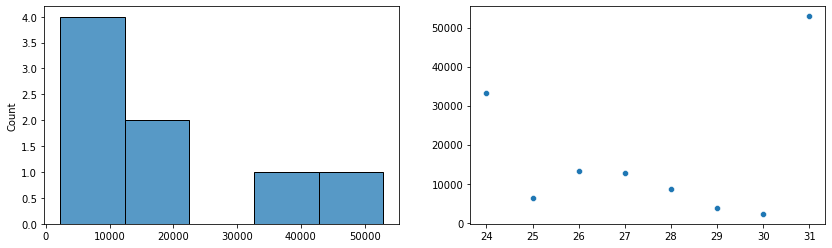

In [98]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

validator_lin = RegressionValidator(ElasticNet, l1_ratio=0.375, alpha=2.5e-4, normalize=True)
errors['elastic'] = validator_lin.validate(CONFIG['validation_window'], train, target_test)

_, axs = plt.subplots(1, 2, figsize=(14, 4))

sns.scatterplot(x=errors['elastic'][0], y=errors['elastic'][1], ax=axs[1])
sns.histplot(errors['elastic'][1], ax=axs[0])

np.mean(errors['elastic'][1])

In [33]:
from xgboost import XGBRegressor

37182.60303218965

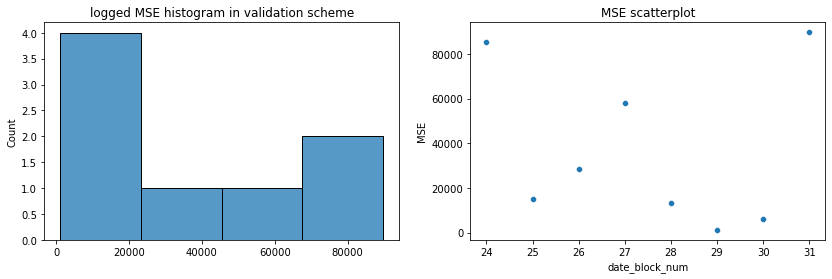

In [100]:
validator_gdbt = RegressionValidator(XGBRegressor, max_depth=40)
errors['GBDT'] = validator_gdbt.validate(CONFIG['validation_window'], train, target_test)

_, axs = plt.subplots(1, 2, figsize=(14, 4))

axs[0].set_title("logged MSE histogram in validation scheme")
axs[1].set_title("MSE scatterplot")
axs[1].set_xlabel('date_block_num')
axs[1].set_ylabel('MSE')

sns.scatterplot(errors['GBDT'][0], errors['GBDT'][1], ax=axs[1])
sns.histplot(errors['GBDT'][1], ax=axs[0])

np.mean(errors['GBDT'][1])

In [35]:
def get_statistics(report):
    stat = report.copy()
    stat['residuals'] = stat['predicted'] - stat['true_values'] 
    stat['id'] = stat.index
    stat['abs_residuals'] = stat['residuals'].abs()
    stat['percentage'] = 2*(stat['residuals'])/(stat['true_values'] + stat['predicted'])
    return stat

def stat_info(errors):
    mean_residuals = pd.DataFrame({'abs_resid': [0 for _ in range(438)], 'resid': [0 for _ in range(438)]}, [i for i in range(438)])
    residual_series = None
    for _idx, report in enumerate(errors[2]):
        residuals = get_statistics(report)
        mean_residuals['abs_resid'] += residuals['abs_residuals']
        mean_residuals['resid'] += residuals['residuals']
        resids = residuals['residuals'].reset_index()
        resids['window'] = _idx
        resids['true_value'] = residuals['true_values']
        resids.set_index(['index', 'window'], inplace=True)
        if residual_series is None:
            residual_series = resids
        else:
            residual_series = pd.concat([residual_series, resids])
    mean_residuals /= len(errors[2])
    return mean_residuals, residual_series, residuals

In [101]:
proceed_residuals = {}

proceed_residuals['elastic'] = stat_info(errors['elastic'])
proceed_residuals['GBDT'] = stat_info(errors['GBDT'])

<AxesSubplot:xlabel='residuals', ylabel='Count'>

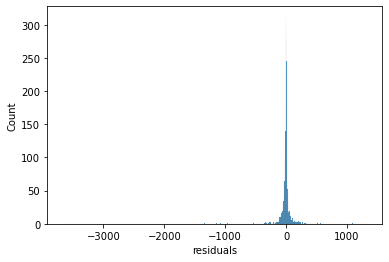

In [37]:
stable_residual_interval = proceed_residuals['elastic'][1].reset_index().rename(columns={'index': 'id'}).merge(idx)
stable_residual_interval['abs_residuals'] = abs(stable_residual_interval['residuals'])
sns.histplot(data=stable_residual_interval, x='residuals')

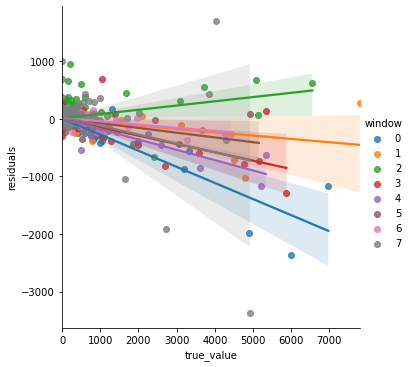

In [102]:
sns.lmplot(data=proceed_residuals['elastic'][1].reset_index(), x='true_value', y='residuals', hue='window')

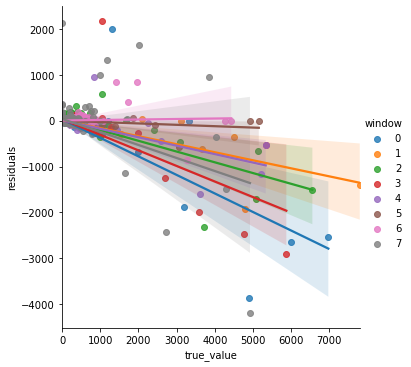

In [103]:
sns.lmplot(data=proceed_residuals['GBDT'][1].reset_index(), x='true_value', y='residuals', hue='window')

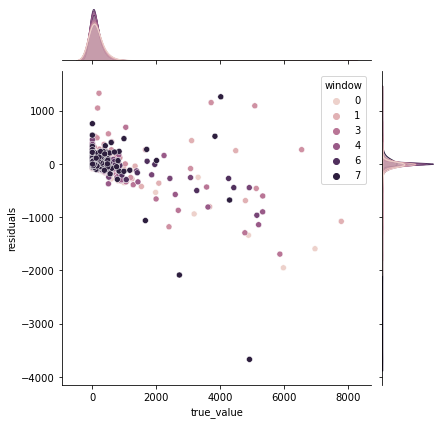

In [40]:
sns.jointplot(data=proceed_residuals['elastic'][1].reset_index(), x='true_value', y='residuals', hue='window')

In [105]:
analitycs_set = proceed_residuals['elastic'][1].reset_index()

In [146]:
underestimated_outliers = analitycs_set[(analitycs_set.true_value > 2000) & (analitycs_set.residuals < 0)]['index'].unique()
(analitycs_set[
    (analitycs_set.true_value > 2000) & (analitycs_set.residuals < -100)
    ]
    .rename(columns={'index': 'id'})
    .merge(idx.loc[:, ['id', 'pair_name']]))

,id,window,residuals,true_value,pair_name
0,187,0,-1978.985221,4889.0,Москва - Игры
1,187,1,-1021.165856,4793.0,Москва - Игры
2,187,3,-778.797658,4776.0,Москва - Игры
3,187,4,-856.694310,3620.0,Москва - Игры
4,187,5,-438.712922,3074.0,Москва - Игры
5,187,6,-374.000171,3269.0,Москва - Игры
6,187,7,-374.873749,4296.0,Москва - Игры
7,188,0,-565.936912,3312.0,Москва - Игры PC
8,188,1,-100.690716,3108.0,Москва - Игры PC
9,188,3,-592.321536,3577.0,Москва - Игры PC


In [144]:
underestimated_outliers = [187, 188, 191, 193, 194, 317, 108, 315]

array([187, 188, 191, 193, 194, 317, 108, 315])

In [141]:
def residual_plot(dataset, sets):
    _df = dataset[dataset['id'].isin(sets) == True].merge(idx)
    return _df.groupby(['month_block', 'pair_name']).item_cnt_month.sum().unstack().fillna(0).plot(figsize=(20, 10))

<AxesSubplot:xlabel='month_block'>

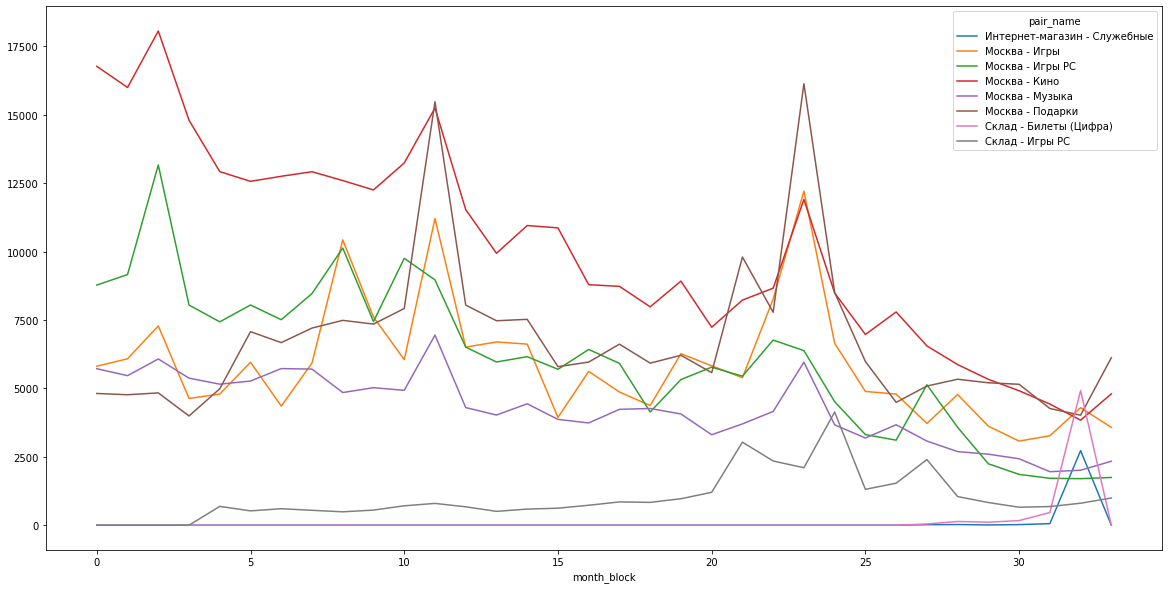

In [145]:
residual_plot(task_df['test'], underestimated_outliers)

# Real magic stuff (I hope it would work)

In [399]:
exp_train = train.copy()

grid_tuning = 1e5

exp_train['target'] = np.exp(exp_train['target'] / grid_tuning)
log_back_tr = lambda series: np.log(series)*grid_tuning

In [370]:
from sklearn.metrics import mean_squared_error as mse

def get_features(date, train_df):
    return train_df[train_df.window == date].set_index(['id', 'window']).sort_index().drop('index', axis=1)
        
def get_target(date, target_vector):
    return target_vector.reset_index()[target_vector.reset_index().window == date].set_index(['id', 'window']).sort_index().drop('index', axis=1)

class RegressionValidator__transform:
    """
        Hardcoded for a while
    """
    def __init__(self, model, back_transform,*args, **kwargs):
        self.model = model(**kwargs)
        self._transform = back_transform
        
    def validate(self, cfg, joined_dataset, test_target):
        """
            Validate selected model on a dataset

            Input:

            1) 'joined_dataset' has the following format: ['id', 'window', feature_1, ... , target]
            2) 'test_target': ['id', 'window', 'target']
            3) 'cfg' is a dictionary containig ('min_window', 'max_window') in keys


            Out:
                - Residual statistics
        """
        train_df = joined_dataset.drop(['target'], axis=1)
        target_vector = joined_dataset.loc[:, ['id', 'window', 'target']]
        
        def get_features(date):
            return train_df[train_df.window == date].set_index(['id', 'window']).sort_index()
        
        current_date = cfg['min_window']
        max_date = cfg['max_window']
        
        errors = [
            [], [], []
        ]
        
        while current_date < max_date:
            current_features = get_features(current_date)
            validation_window = get_features(current_date + 1)
            
            current_target = get_target(current_date, target_vector)
            validation_target = get_target(current_date + 1, test_target)

            fitted = self.model.fit(current_features, current_target)

            predictions = self.model.predict(validation_window)
            
            predictions = self._transform(predictions)

            if predictions.transpose().shape[0] == 1:
                predictions = predictions.transpose()[0]
            else:
                predictions = predictions.transpose()
        
            errors[0].append(current_date)
            assert validation_target.loc[:,'target'].shape == predictions.shape, f'Shapes are pred:{validation_target.loc[:,"target"].shape} and truth:{predictions.shape}\nCurrent validation set: {current_date}'
            errors[1].append(mse(validation_target.loc[:,'target'].to_list(), predictions))
            
            report = pd.DataFrame({'true_values': validation_target.loc[:,'target'].to_list(), 'predicted': predictions})
            errors[2].append(report)
            
            current_date += 1
        
        return errors

<AxesSubplot:>

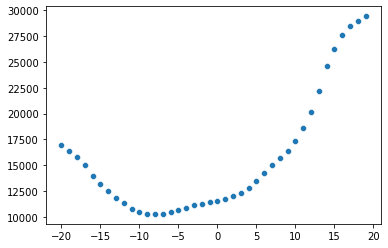

In [409]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

lis = [[], []]

for alpha_ in range(-20, 20):
    validator_lin = RegressionValidator__transform(ElasticNet, log_back_tr, l1_ratio=0.5, alpha=10**(-1 + alpha_/20.0))

    err = validator_lin.validate(CONFIG['validation_window'], exp_train, target_test)

    # _, axs = plt.subplots(1, 2, figsize=(14, 4))

    # sns.scatterplot(x=errors['exp_elastic'][0], y=errors['exp_elastic'][1], ax=axs[1])
    # sns.histplot(errors['exp_elastic'][1], ax=axs[0])

    lis[0].append(alpha_)
    lis[1].append(np.mean(err[1]))

sns.scatterplot(*lis)

mean error: 10286.614937486076


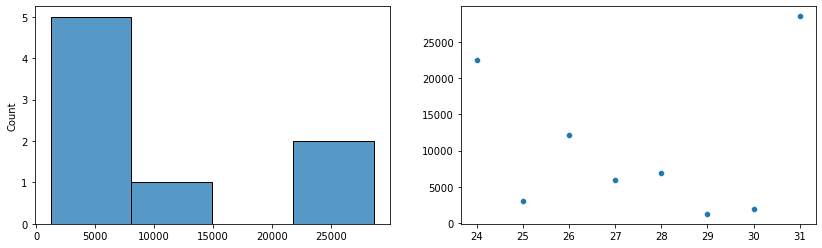

In [412]:
validator_lin = RegressionValidator__transform(ElasticNet, log_back_tr, l1_ratio=0.5, alpha=10**(-1.4))

errors['exp_elastic'] = validator_lin.validate(CONFIG['validation_window'], exp_train, target_test)

_, axs = plt.subplots(1, 2, figsize=(14, 4))

sns.scatterplot(x=errors['exp_elastic'][0], y=errors['exp_elastic'][1], ax=axs[1])
sns.histplot(errors['exp_elastic'][1], ax=axs[0])

print(f'mean error: {np.mean(errors["exp_elastic"][1])}')

In [413]:
proceed_residuals['exp_elastic'] = stat_info(errors['exp_elastic'])

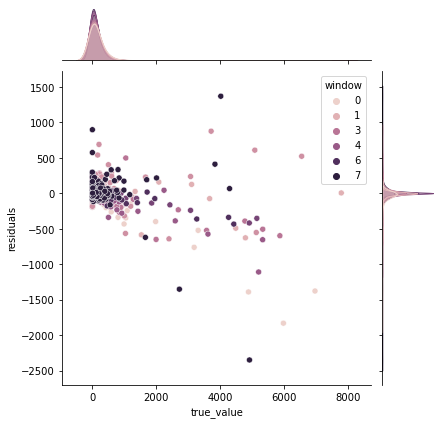

In [414]:
sns.jointplot(data=proceed_residuals['exp_elastic'][1].reset_index(), x='true_value', y='residuals', hue='window')